<a href="https://colab.research.google.com/github/mkreitze/Math6181/blob/main/A1_Matthew_Kreitzer_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 (Math 6181)
### Matthew Kreitizer 


Below are the libraries I used. I ran some pip installs just to make sure everything was up to date and ready, this is not needed but is good practice. <br />

## General notes:
For this first assignment I only used colab. Given how useful these types of files are, I will use Jupyter notebooks for future work and will probably stick this in most of my github work. <br />

All of my variables are camelCase, while all variables previously defined, such 
as X_0, were kept. <br />
Sometimes, to verify that a test is valid the following code is used:

```python
assert jnp.isclose(a,b)
``` 

The function $isclose$ yields $True$ if the two values a,b are within a tolerance and $False$ if not. Note the relative default is defaulted to $10^5$ while the absolute tolerance is defaulted to $10^8$. The assert keyword yields an assertion error if the logical statement does not evaluate to True. Thus if any code using an assert command finished to completion, the check yields true. This method of testing mimicked from code provided in the Final Project jupyter file. 

## A quick note:
It should also be noted that when possible i used the jax.numpy version of functions. Sometimes, these were not implemented well (for example the jax.numpy.searchsorted command), in these cases I used the numpy versions. <br />


## Imports and installs:
Please run the two code snippets below to ensure all code runs as intended. 

In [ ]:
# python libraries to install
!pip install jax
!pip install numpy
!pip install matplotlib


In [ ]:
# Imports from downloaded libraries
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import random


# Question 1: Quick simulation a Markov chain update. 
## General Problem: <br /> 
Develop a function "Markov_chain_sim" which simulates one update of a Markov chain given the: initial state; $X_0 \in S$ (with $S$ being the state space with elements $\{0, ... ,N_{state} - 1\}$ and $N_{state} \in \mathbb{N}$), the transition matrix; $P \in \mathbb{R}^{N_{state} × N_{state}}$ and a random uniform variable on $(0,1)$; $U$ .  <br /> 
### Solution: 
To simulate a Markov chain, consider what $X_1$ could be, given any $U$. In other words, consider the probability distribution of going from $X_0$ to any other state. <br />
This probability distribution is represented by a row of the transition matrix $P$. To find the exact row, simply enumerate $S$ (this is technically already done for us) and generate $P$ using the enumerated states as the dimensions in the matrix. This allows the enumerated value of every state in $S$ to have a probability distribution represented by the same row in $P$. Thus the probability distribution of $X_0$ going to another state is the row of $P$ with the enumerated value of $X_0$. <br />
Next, we must define how $U$ can change the state of $X_0$. That is to say, what does a value of $U = 0.8$ mean? In terms of convention, we shall consider $U$ changing $X_0$ to the value of column whose cumulative sum contains the value of $U$. This is best explained using the simple example below. <br />
### Example:
Given:
$$P =
 \begin{pmatrix}
  0.5 & 0.5 \\
  0.7 & 0.3 
 \end{pmatrix}$$ 
$$U = 0.8$$
$$X_0 = 1 $$
Then $X_1 = 1$ since $U = 0.8 \in (0,0.3+0.7]$. If instead $U = 0.2$ then $X_1 = 0$ since $U \in (0,0.3]$. <br />
Since a probability distribution sums to one, it must be changed. To do this we take the cumulative sums of the elements in $P[X_0]$, then find which summed interval $U$ fits in, this interval giving $X_1$. While a seemingly daunting task to code up, it can easily be done using the numpy library.<br />


## Code comments
>  If $v \in \mathbb{R}^{i}$ the cumulative sum vector $w$ of $v$ is given by $ w \in \mathbb{R}^i$ with $w_j = \sum_{i=1}^j{v_i}$, $0\leq j \leq i$ (for example: if $ v = [0.3,0.3,0.3] \rightarrow w = [0.3,0.6,0.9] $) can be generated by the following python code:  
```python
w = np.cumsum(v)
```
> If $v \in \mathbb{R}^{i}$, and $a \in \mathbb{R}$ then the index that satisfies $ v[i] < a \leq v[i+1]$ can be found via the python code: 
```python
X_1 = np.searchsorted(cumVec,U,side = 'left')
```
Note if the function has no interval to contain $a$, then it outputs $i$. 



In [ ]:
def Markov_chain_sim(P,X_0,U):
  #Input: 
  #  P = An array of shape (N,N) where the entries are non-negative and each row sums to 1  
  #  x_0 = An integer from the state space [0,N-1]
  #  U = A real number between [0,1] which is generated as a uniform random variable
  #Ouput:
  #  An integer from the state space [0,N-1] which gives the location of the Markov chain at time X_1 

  probDist = P[X_0] # takes the probabily distribution for transitions of state X_0
  cumVec = np.cumsum(probDist) # generates the cumulative sum to incorporate U

  # Note, each interval is [x,y) due to the choice of side = left. 
  X_1 = np.searchsorted(cumVec,U, side = 'left') 
  return X_1

testMatrix = np.array([[0.5,0.25,0.25],[0.7,0.2,0.1],[0.3,0.3,0.3]])
# since 0.75 = 0.5 + 0.25, should be = 1
assert jnp.isclose(Markov_chain_sim(testMatrix,0,0.75),1)
# since 0.95 < 0.7 + 0.2 + 0.1, should be = 2 
assert jnp.isclose(Markov_chain_sim(testMatrix,1,0.95),2)
# since 0.3 < 0.55 < 0.3 + 0.3, should be = 1
assert jnp.isclose(Markov_chain_sim(testMatrix,1,0.8),1)
print(f"Test matrix \n {testMatrix}")

Test matrix 
 [[0.5  0.25 0.25]
 [0.7  0.2  0.1 ]
 [0.3  0.3  0.3 ]]


# Question 2: Markov chain weather model. 
## General Problem: <br /> 
Consider a weather simulation which takes in states of rainy, $R$ and sunny, $S$. This simulation has defined values for state transitions given by the following table:

State|Chance for R|Chance for S
-|-|-
$ASS$|50%|50%
$ARS$|30%|70%
$RRR$|10%|90%
$ARR$|25%|75%
$AAR$|40%|60%

Note: $A$ represents either $S$ or $R$. Also all rules appear in a conditional pattern. For example: $RRR$'s rule overwrites $AAR$'s rule. The problem involves developing a Markov chain processes to accurately model this weather system.



## (a) Defining the Markov chain
To generate a Markov chain, a state space must be defined. Since the weather extends to three possible days, it is easiest to define $S$ as all three letter strings with the alphabet $\{R,S\}$. Drawing this as a directed graph with the state space $ S = \{ \{RRR\}, \{RRS\}, \{RSR\}, \{SRR\}, \{RSS\}, \{SRS\}, \{SSR\}, \{SSS\} \}$ gives the following Markov chain: <br />
![Image](https://i.imgur.com/59zMyJk.jpg) <br />
Turning this digraph into a transition matrix $P$ yields:
$$P =
 \begin{matrix}
  & \{RRR\} & \{RRS\} & \{RSR\} & \{SRR\} & \{RSS\} & \{SRS\} & \{SSR\} & \{SSS\}\\
  \{RRR\} & \frac{1}{10} & \frac{9}{10} & 0 & 0 & 0 & 0 & 0 & 0\\
  \{RRS\} & 0 & 0 & \frac{3}{10} & 0 & \frac{7}{10} & 0 & 0 & 0\\
  \{RSR\} & 0 & 0 & 0 & \frac{4}{10} & 0 & \frac{6}{10} & 0 & 0\\
  \{SRR\} & \frac{25}{100} & \frac{75}{100} & 0 & 0 & 0 & 0 & 0 & 0\\
  \{RSS\} & 0 & 0 & 0 & 0 & 0 & 0 & \frac{5}{10} & \frac{5}{10}\\
  \{SRS\} & 0 & 0 & \frac{3}{10} & 0 & \frac{7}{10} & 0 & 0 & 0\\
  \{SSR\} & 0 & 0 & 0 & \frac{4}{10} & 0 & \frac{6}{10} & 0 & 0\\
  \{SSS\} & 0 & 0 & 0 & 0 & 0 & 0 & \frac{5}{10} & \frac{5}{10}\\
 \end{matrix} $$
 <br />
When written in this way, the patterns between certain states becomes much more clear. There is probably a better generalize $P$ for an arbitrary alphabet and arbitrary length. To do this, every possible state could be generated using permutation functions in Pythons itertools library. The transitions could be found by connecting permutations that can be accessed through single additions. In fact, graphs that describe this are known are de Brujin graphs and method to generate ones for arbitrary length and alphabets are known in mathematical literature. Thus there must be a generalized method to make $P$. But since this problem only deals with a three length string for an alphabet of size two, it is easiest to hardcode it.  <br />


## (b) Coding up the Markov chain
Since the Markov chain has been defined, it only needs to be coded. <br />
The following function generates the transition matrix. Since we are hardcoding the matrix, there is no need to pass in any variables. <br />

### Code Comments
> Since we are assigning values to a jax array, if $a \in \mathbb{R}^{i\times j}$ assigning a value as $a_{i,j} = v$ is done as follows:
```python
a = a.at[i,j].set(v)
``` 
<br />
> To make the code more readable semicolons were put in place for declarations and sets. <br /><br />
> To not have so many variables floating around, only the percentage to generate rain was kept.<br /><br />


In [ ]:
def makePMatrix():
  #Input: None
  #Output: Filled transition matrix. Typ  e jnp.array(), size(8,8)
  tMatrix = jnp.zeros([8,8])
  
  aSS = 0.5;aRS = 0.3;aRRR = 0.1;aRR = 0.25;aR = 0.4 #percentage of rain for SS, RS, RRR, RR, R type states 

  tMatrix = tMatrix.at[0,0].set(aRRR); tMatrix = tMatrix.at[0,1].set(1-aRRR) #input RRR transitions
  tMatrix = tMatrix.at[1,2].set(aRS); tMatrix = tMatrix.at[1,4].set(1-aRS) #input RRS transitions
  tMatrix = tMatrix.at[2,3].set(aR); tMatrix = tMatrix.at[2,5].set(1-aR) #input RSR transitions
  tMatrix = tMatrix.at[3,0].set(aRR); tMatrix = tMatrix.at[3,1].set(1-aRR) #input SRR transitions
  tMatrix = tMatrix.at[4,6].set(aSS); tMatrix = tMatrix.at[4,7].set(1-aSS) #input RSS transitions
  tMatrix = tMatrix.at[5,2].set(aRS); tMatrix = tMatrix.at[5,4].set(1-aRS) #input SRS transitions
  tMatrix = tMatrix.at[6,3].set(aR); tMatrix = tMatrix.at[6,5].set(1-aR) #input SSR transitions
  tMatrix = tMatrix.at[7,6].set(aSS); tMatrix = tMatrix.at[7,7].set(1-aSS) #input SSS transitions
  return(tMatrix)
print(f"P = \n {makePMatrix()}")

P = 
 [[0.1  0.9  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.3  0.   0.7  0.   0.   0.  ]
 [0.   0.   0.   0.4  0.   0.6  0.   0.  ]
 [0.25 0.75 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.5  0.5 ]
 [0.   0.   0.3  0.   0.7  0.   0.   0.  ]
 [0.   0.   0.   0.4  0.   0.6  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.5  0.5 ]]




All that is missing, is defining $X_0$ and a certain number of iterations. Since the current day or previous day must have started with sunny, the initial state must either be $RSS, SSS$ with equal probability. This gives $X_0 = [0,0,0,0,0.5,0,0,0,0.5]$.  With this the code to run the Markov chain for 0 to 100 iterations was done. <br /> 


### Code Comments
> To more efficiently code the result, the power of a matrix is used to develop the Markov chain. If $A \in \mathbb{R}^{i\times i}$ the matrix power $M = A^n$ is computed through:
```python
M = jnp.linalg.matrix_power(A,n)
```
It should be noted that this method does not first diagonalize the matrix, instead using repeated matrix squaring. While technically less efficient, developing code to diagonalize, then take the power is not worthwhile given $n \in (0,100)$. <br /> <br />

> To quickly run the Markov chain with n from 0 to 100, vectorization was considered. However, since each episode is not found iteratively, with  each Markov chain is resolved by a matrix power calculation, vectorization was forgone for a simple for loop.

> The project files specify only the number of iterations being passed through, this implies a hardcoded $P$ matrix and $X_0$. While this does make sense for this problem, a more general function was used as it may be useful in future work.



Rain probability after 100 updates is 38.64%


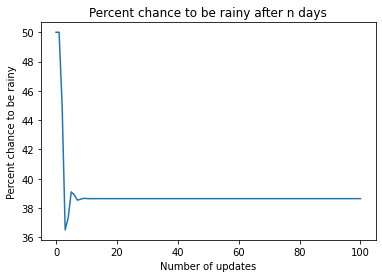

In [ ]:
def runMarkov(initState, numOfIts, tMatrix):
  
  # Input: 
  # initState: a jnp array of shape (X,), showing initial state
  # numOfIts: integer, showing number of iterations to do
  # tMtarix: a jnp array of shape (X,X), shows the transition matrix for the Markov chain
  
  # Output:
  # xF: a jnp array of shape (X,) showing the probability distribution after numOfIts updates

  xF = jnp.matmul(initState,jnp.linalg.matrix_power(tMatrix,numOfIts)) # based on documentation, jax uses squaring method.  
  return(xF)

tMatrix = makePMatrix() # gets the transition matrix 

x0 = jnp.array([0,0,0,0,0.5,0,0,0.5]) # inital state (last two are S state)
rainProbs = jnp.array([]) # holds probabilities for rain, used to plot

for i in range(100+1): # run through 0 -> 100 iterations
  xI = runMarkov(x0,i,tMatrix) # finds the probability distribution after i updates
  rainProbs = jnp.append(rainProbs,xI[0] + xI[2] + xI[3] + xI[7]) # sticks in the probabilty for rain after i updates

print(f"Rain probability after 100 updates is {rainProbs[-1]*100:.2f}%")

# Plots data
toPlot = jnp.stack(rainProbs*100) # Turns data into percentage
plt.title("Percent chance to be rainy after n days")
plt.ylabel("Percent chance to be rainy")
plt.xlabel("Number of updates")
plt.plot(toPlot)


## (c) Finding $v_{∞}$
While the Markov chain can accurately predict the chance for rainy or sunny, it is an approximation. To get an exact answer, the following equation must be solved:
$$ v_{∞} = v_{∞}*P$$
This equation is solved by computing the eigenvector eigenvalue problem. Relating this to the power method to find $x_i$ earlier, eigenvectors with eigenvalues less than one will converge to zero while eigenvalues larger than one will produce no limit, and therefore no answer. This means only eigenvectors with eigenvalues of 1 can converge. Thus $v_{∞}$ will be the eigenvector with an eigenvalue of 1. As seen in class $v_{∞}$ must be unique therefore, $v_{∞}$ will be the scaled eigenvector with an eigenvalue of 1. The code block below calculates $v_{∞}$ for this problem. <br />
Also, it should be noted that the initial state does not affect $v_{∞}$, this is a consequence of the Markov chains states being fully connected. 

### Code Comments
>  If $A \in \mathbb{R}^{i\times i}$ and $x \in \mathbb{R}^{i}$, the equation $x = Ax$ is solved using the following command:  
```python
vals,vects= np.linalg.eig(M)
```
> The output is somewhat messy as the ith eigenvector is stored as vects[:,i]. 
<br /> <br />
>  If $v \in \mathbb{R}^{i}$ the equation $\sum_{a=1}^i{v_a} = s$ is solved using the following command:  
```python
s = jnp.sum(v)
```


In [ ]:

def findVInf(tMatrix):

  vals,vects= np.linalg.eig(tMatrix) # Generate eigenvalues and eigenvectors for P 

  # The following code finds the eigenvector with the largest eigenvalue. 
  val = 0
  i = 0
  bigVal = vals[0] 
  for idx,val in enumerate(vals):
    if (abs(bigVal) <= abs(val)): #find the biggest eigenvector, which must = 1
      bigVal = val
      i = idx

  return(vects[:,i])

tMatrix = makePMatrix() # as before, generates the P matrix
eigen = findVInf(tMatrix)

print(f"Eigen vector: \n {eigen}") #prints the eigenvector
print("Normalized eigen vector:")  #prints normalized eigenvector
normedEigen = (1/jnp.sum(eigen)*eigen )
print(normedEigen)

Eigen vector: 
 [-0.35355338+0.j -0.35355338+0.j -0.35355338+0.j -0.35355338+0.j
 -0.35355338+0.j -0.35355338+0.j -0.35355338+0.j -0.35355338+0.j]
Normalized eigen vector:
[0.125+0.j 0.125+0.j 0.125+0.j 0.125+0.j 0.125+0.j 0.125+0.j 0.125+0.j
 0.125+0.j]


The above eigenvector is concerning, as somehow there is an equal chance to find any state. This should not be the case. To find the percent chance of rain, we must add all states that end in rain.  <br />
Therefore:

In [ ]:
rainLimit = normedEigen[0] + normedEigen[2] + normedEigen[3] + normedEigen[7] # Corresponds to states: RRR RSR SSR SSR 
print(f"Chance of rain  = {rainLimit}")

Chance of rain  = (0.5+0j)


Through the PEAR review, it was suggested using row wise multiplication, not column wise. To do this, the matrix can be transposed using:
``` python 
 np.transpose(tMatrix)
 ```
Using this, the following chance of rain can be computed. 

In [ ]:

tMatrix = makePMatrix() # as before, generates the P matrix

vals,vects= np.linalg.eig(np.transpose(tMatrix)) # Generate eigenvalues and eigenvectors for P^T 

# The following code finds the eigenvector with the largest eigenvalue. 
val = 0
i = 0
bigVal = vals[0] 
for idx,val in enumerate(vals):
  if (abs(bigVal) <= abs(val)): #find the biggest eigenvector, which must = 1
    bigVal = val
    i = idx

print(f"Eigen vector: \n {vects[:,i]}") #prints the eigenvector
print("Normalized eigen vector:") 
normedEigen = (1/jnp.sum(vects[:,i])*vects[:,i] )
print(normedEigen)
rainLimit = normedEigen[0] + normedEigen[2] + normedEigen[3] + normedEigen[7] # Corresponds to states: RRR RSR RRS SSR 
print(f"Chance of rain  = {np.real(rainLimit)*100:.2f}%")

Eigen vector: 
 [-0.0740355 +0.j -0.26652777+0.j -0.19989584+0.j -0.26652777+0.j
 -0.4664236 +0.j -0.39979166+0.j -0.4664236 +0.j -0.4664236 +0.j]
Normalized eigen vector:
[0.0284091 +0.j 0.10227274+0.j 0.07670456+0.j 0.10227274+0.j
 0.1789773 +0.j 0.15340911+0.j 0.1789773 +0.j 0.1789773 +0.j]
Chance of rain  = 38.64%


This is extremely similar to the simulated answer, which is the expected. Yay. It was mentioned during PEAR that the final answer should be around 37%. This discrepancy is not accounted for.

# Question 3
## General problem
Consider a monkey sitting at a typewriter. Assuming the monkey is completely random in pressing the keys (though honestly the monkey will probably have a preference to certain buttons over others) what is the chance that the monkey will generate a certain string over a given number of presses. Furthermore, what is the expected number of presses for the string to appear. The goal of this problem is to find the expected number of button presses for a certain string to appear using a Markov Chain. To do this we need to define some terms:<br />
> $n_{buttons}$, that being the number of keys on our typewriter. (all keys are assumed to be unique). <br />
> $n_{word}$, this is the length of the string we are analyzing. <br />
> Target, this is the word that must appear in a vector of $n_{word}$ (For most cases the word 'ABRACADABRA' will be our target word). <br />



### (a) Start with the naive method
One intuitive method is to set the state space as every possible word that is of length $n_{word}$. This is very similar to the approached used in the previous question. Since each character can be one of 26 letters, the number of possible strings for a given word length is simply $26^{n_{word}}$. <br />
The issue with this comes from the size of the transition matrix. Since the transition matrix needs to contain the probability of each state changing to another, it has dimension $(|S|,|S|)$ with $S$ being the state space. While this would be a relatively sparse matrix, a matrix of $26^{n_{word}}$ would quickly be difficult to represent on a computer, as a word such as ABRACADABA, which has $n_{word} = 10$, would require  $P \in \mathbb{R}^{1.411671e+14 \times 1.411671e+14}$. If we ignore methods to condense sparse matrices (such as CSR matrices) and consider $P$ to at least require 1 byte to represent every element, that would mean $P$ would require at least 1.992815e+28 bytes or  19928150000000000, Terabytes. For context, most modern computer hard drives can hold between 1-2 Terabytes. Therefore, this method is not viable.


### (b) A better method
Instead of generating this naive method, consider using a Markov chain where we instead construct the target word. That would change $S$ to be every segment, going left to right, of the target. Using ABRACADABRA as an example, we obtain $S$ as follows ( it is represented as a matrix to make it fit nicer on the page):
$$S =
 \begin{matrix}
  A & AB & ABR & ABRA \\
  ABRAC & ABRACA & ABRACAD & ABRACADA \\
  & ABRACADAR & ABRACADARA \\
 \end{matrix}$$ 
This gives $|S| = 10 = n_{word}$. The only issue with this comes from the string of words not having any segment of the target in it. To account for this we include a no word state, represented by $\phi$. This changes $|S| = n_{word} + 1$.


### (c) Constructing $P$ for the better method
To generate $P$ for this new Markov chain, lets consider the simple example where $n_{buttons} = 6$ and the states $\{0,0\}$ and $\{0,1\}$ are considered. The directed graph of the Markov chains for these targets is shown below:
![An image](https://i.imgur.com/MUvAwBw.jpeg) <br/>

Both graphs represent the generation of the sequences $\{0,0\}$ and $\{0,1\}$ respectively. A value of $\phi$ represents any value which is not desired, for example $\{4,2\}$ is represented in $\{\phi,\phi\}$. The only way to traverse from $\{\phi,\phi\}$ to a relevant state, is to roll a 0. The main difference comes from how $\{0,\phi\}$ can fail. For the target of $\{0,1\}$, the $\{0,\phi\}$ can fail by rolling a 0, but in doing so, it goes back into the $\{0,\phi\}$ state. This is essentially different from the $\{0,0\}$ target, as a roll of 0 attains the target. In other words, having two states that are distinct allows for the intermittent state to 'fail progressively' while the non distant case can only fail or succeed. Also, it should be noted that once the desired string appears, the state never changes from the "complete" state.<br/>
This is extremely useful as it allows us to easily generate the $P$ matrices for both of these Markov chains.
$$P_{\{0,0\}} =
 \begin{matrix}
  \frac{5}{6} & \frac{1}{6} & 0 \\
  \frac{5}{6} & 0 & \frac{1}{6} \\
  0 & 0 & 1 & \\
 \end{matrix}
 P_{\{0,1\}} =
 \begin{matrix}
  \frac{5}{6} & \frac{1}{6} & 0 \\
  \frac{4}{6} & \frac{1}{6} & \frac{1}{6} \\
  0 & 0 & 1 & \\
 \end{matrix}
 $$ 
One important observation is that the expected number of buttons presses to generate $\{0,0\}$ must be higher for $\{0,1\}$ since $\{0,1\}$ can 'fail progressively' while $\{0,0\}$ will not.


## (d) The general program
To start, we must construct the transition matrix $P$, and doing so in an efficient way requires us to analyze how to make $P$ in general. <br />
The first thing to notice, is the obvious pattern in $P$ that appeared in the simpler case of 5(b). Since every state must map to the next, the upper diagonal of $P$ must be $\frac{1}{n_{buttons}}$. This transition represents going onto the next letter of the word. <br />
Of course, the chance to return to no progress, or  $p_{\phi}$. However, this value is not constant and depends on the current state. As seen in 5(b), this occurs because failure to transition to the next state does not force the state $\phi$. The best way to show this is through an example.
### Example:
Given:
$$target = \{0,1,0,2\} $$ 
$$n_{buttons} = 6$$
Consider generating $P$. Unlike the simpler problem in 5(b) there are more ways to 'fail progressively'. For example the state $\{0,1,0\}$ can transition to state $\{0,1\}$ if the state fails at attaining $2$ and instead gets $1$. It can also transition to the $\{0\}$ state if the dice attains a $0$. Otherwise $\{0,1,0\}$ returns to the $\{\phi\}$ state. Since everything occurs with a $\frac{1}{6}$ chance, the probability distribution (considering $\phi$ to be the 0th state, and enumerating based on cardinality of $X_i$)is $P_{\{0,1,0\}} = [\frac{3}{6},\frac{1}{6},\frac{1}{6},0,\frac{1}{6}]$. Extending this to the rest of the matrix yields. 

$$P_{\{0,1,0,2\}} =
 \begin{matrix}
  & \{\phi\} & \{0\} & \{0,1\} & \{0,1,0\} & \{0,1,0,2\}\\
  \{\phi\} & \frac{5}{6} & \frac{1}{6} & 0 & 0 & 0\\
  \{0\} & \frac{4}{6} & \frac{1}{6} & \frac{1}{6} & 0 & 0\\
  \{0,1\} & \frac{4}{6} & 0 & 0 & \frac{1}{6} & 0\\
  \{0,1,0\} & \frac{3}{6} & \frac{1}{6} & \frac{1}{6} & 0 & \frac{1}{6}\\
  \{0,1,0,2\} & 0 & 0 & 0 & 0 & 1\\
 \end{matrix} $$
 Note: there is a very interesting interaction in the third row. The $\{0,1\}$ can go to $\{0\}$ and $\{0,1,0\}$ if a 0 is rolled. But since $\{0,1,0\}$ is farther in progress, $\{0,1,0\}$ overrides the $\{0\}$ state transition chance.<br />
Connecting this to the expected value is done through the Bellman equation. But let us deal with coding up $P$.


## Coding P
### Recording the states:
<br />
Since we need to map which states can transition to one another, each state must be recorded. Each state can be found by simply cutting up the target. To store all possible sequences, I used a matrix of size $(n_{word},n_{word})$ and input each segment of the target sequence in its rows. <br />

### Code Comments
> The states could be stored using a 2D list, while turning it into a jax array may take longer I reasoned it would be better to use a standardized datatype unless forced not to.


In [169]:
def stateMatrix(word_sequence):
  # Input: 
  # word_sequence, a jnp array of size (n_word,), is the target word
  # Output:
  # states, a jnp array of size (n_word, n_word) that holds all relevant segements of the target word 
  wordSize = jnp.size(target)
  states = jnp.zeros([wordSize,wordSize]) # generates empty matrix 
  for i in jnp.arange(1,wordSize+1):  
    states = states.at[i-1,0:i].set(word_sequence[0:i]) # Note, could be a 2D list. While the upper triangle is filled with zeros, I do not know if there is a way to truncate it
  return(states)

target =jnp.array([0,1,1,3]) # target segement is represented by the string 0113
print("States") 
print(stateMatrix(target))

States
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 3.]]


### Finding which states can transition to one another
To see if a state can transition two checks must happen. <br />
To start, the first $n-1$ characters of the destination state match the last $n-1$ characters of the source state. <br />
> For example consider if $\{0,1\}$ can transition to itself. Since the first character from the right of $\{0,1\}$ does not match the first character from the left, it cannot transition. The only way to properly find this is with two for loops. <br />

After all of these possible transitions are found, two states must check if they override one another by checking if their final characters are the same.<br /> 

> For example consider $\{0,1\}$ going to $\{0,1,0\}$. If the button of $0$ is pressed, $\{0,1\}$ can attain the states $\{0\}$ or $\{0,1,0\}$. Since $\{0,1,0\}$ has more progress than $\{0\}$, $\{0,1\}$ can only transition to  $\{0,1,0\}$ and $\phi$. <br />

## Code comments:

The overriding of transitions was not done, I accidentally used a test case that did not need this and I did not notice it was implemented until it was too late.


> To check if two states can transition, their segments were compared using the function:
```python
jnp.array_equal(pStep,cStep)
```
This function checks if each array is the same element wise. The main issue is trying to compare empty strings, to get around this the following function was used: <br />
```python
jnp.size(pStep) == 0
```
> To simplify work, it was realized that the next state can always be attained by the previous state. This was done by:
```python
repeats = repeats.at[i,i+1].set(1)
```
> The last row is the success state, and as such the final row must be all zeros followed by a 1. This is done using the following code. 
```python
repeats = repeats.at[numOfStates-1,numOfStates-1].set(1)
```



In [180]:
def canTransition(states, numOfStates):
  # Input: 
  # states, a jnp array of size (numOfStates,numOfStates), full of all segements of target states
  # numOfStates, an integer, represents the size of word_sequence
  
  # Output
  # canTransition, matrix showing where we can transition 

  repeats = jnp.zeros([numOfStates,numOfStates]) #fill new matrix with zeros
  for i in jnp.arange(0,numOfStates-1): # gets a state to see what it can transition to
    transitions = jnp.array([])
    for j in jnp.arange(i,-1,step = -1): # cuts up state into segments 
      pStep = states[j,0:j] # previous segment
      cStep = states[i,i-j+1:i+1] # current segment
      nextState = states[i,0:i+1]
      if jnp.array_equal(pStep,cStep) == True or jnp.size(pStep) == 0: # checks if the segments match, if they do it is considered that they can transition (this is where we should check if any other state overrides this transition)
          transitions = jnp.append(transitions,nextState[i+1])
          repeats = repeats.at[i,j].set(1)
      repeats = repeats.at[i,i+1].set(1) # we can ALWAYS attain the next state, unless the problem is impossible.
  repeats = repeats.at[numOfStates-1,numOfStates-1].set(1) # sets the final state being the success state
  return(repeats)

target =jnp.array([0,1,1,3])
size = jnp.size(target)
buttons = 6
print("States")
print(stateMatrix(target))
print("Valid transition matrix")
print(canTransition(stateMatrix(target), size))


States
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 3.]]
Valid transition matrix
[[1. 1. 0. 0.]
 [1. 0. 1. 0.]
 [1. 0. 0. 1.]
 [0. 0. 0. 1.]]


## Generating $P$
All that is left to do, is populate the transition matrix with the correct probability values. Consider that 4 transitions (and one transition to the $\phi$ state) are allowed and $n_{buttons} = 10$. Since the four transitions can occur with equal probability, each gains $\frac{1}{10}$ as a probability, leaving $\frac{6}{10}$ as the probability to transition to the $\phi$ state. Thus, the $\phi$ state obtains $\frac{n_{buttons} - n_{transitions}}{n_{buttons}}$ while each other state obtains a probability of $\frac{1}{n_{buttons}}$. The only exception to this is the $\phi$ states transitions. By definition it can only attain the first word segment. This is done through the following code


In [174]:
def fillP(numOfStates,N_buttons,transitionStates):
  probs = jnp.ones(numOfStates)*(1/N_buttons) #+1 to include phi state
  tMatrix = jnp.zeros([numOfStates+1,numOfStates+1])

  #we hard code the first row, mainly because phi MUST only connect to the first state 
  tMatrix = tMatrix.at[0,0].set((N_buttons - 1)/N_buttons)
  tMatrix = tMatrix.at[0,1].set(1/N_buttons)
  #figure out phi probability
  for i in jnp.arange(0,numOfStates):
    tMatrix = tMatrix.at[i+1,0].set((N_buttons - jnp.count_nonzero(transitionStates[i]))/N_buttons)
  tMatrix = tMatrix.at[1:numOfStates+1,1:numOfStates+1].set(transitionStates*probs) #stick in calculated transition matrix with probabilties in
  tMatrix = tMatrix.at[numOfStates].set(jnp.zeros(numOfStates+1))# we FORCE I-P to give 0 0 0 0 0 -> 1 by definition, otherwise the bellman equation is non singular
  tMatrix = tMatrix.at[numOfStates,numOfStates].set(1)  #step 4, solve expected t
  return(tMatrix)

target =jnp.array([0,1,1,3])
size = jnp.size(target)
buttons = 6
print("States")
print(stateMatrix(target))
print("Valid transition matrix")
print(canTransition(stateMatrix(target), size))
print("P Matrix")
print(fillP(size,6,canTransition(stateMatrix(target), size)))


States
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 3.]]
Valid transition matrix
[[1. 1. 0. 0.]
 [1. 0. 1. 0.]
 [1. 0. 0. 1.]
 [0. 0. 0. 1.]]
P Matrix
[[0.8333333  0.16666667 0.         0.         0.        ]
 [0.6666667  0.16666667 0.16666667 0.         0.        ]
 [0.6666667  0.16666667 0.         0.16666667 0.        ]
 [0.6666667  0.16666667 0.         0.         0.16666667]
 [0.         0.         0.         0.         1.        ]]


## Solving P
To finally finish this, we must solve $P$. This can be done through a Markov chain with rewards. A reward is defined if part of the target is completed. Since each part of the target can be completed equally each state can be equally rewarded with 1. The only exception to this is the final state with the word fully completed. In this case there will be no reward. This gives the rewards vector $r^T = (0, ... ,0, 1)$. Using this Markov chain with this rewards vector, the Markov chain becomes: 
$$t = Pt - r$$ 
$$(I-P)t = r$$
This system is only solvable if the final requirement that the last row of $(I-P)t$ must be [0,...,0,1] (since this is the only way to get the final element of the reward vector to be 1. 
<br /><br />
### Code Comments

>  If $A \in \mathbb{R}^{i\times i}$ and $x \in \mathbb{R}^{i}$, the equation $ Ax = t$ is solved using the following command:  
```python
np.linalg.solve(pToSolve,r)
```


In [179]:
def solveP(numOfStates,tMatrix):
  #step 4, solve P
  r = jnp.ones(numOfStates+1)
  r = r.at[numOfStates].set(0)
  pToSolve =  jnp.subtract(jnp.identity(numOfStates+1),tMatrix)
  pToSolve = pToSolve.at[numOfStates].set(jnp.zeros(numOfStates+1))# we FORCE I-P to give 0 0 0 0 0 -> 1 by definition, otherwise the bellman equation is non singular
  pToSolve = pToSolve.at[numOfStates,numOfStates].set(1)
  return(np.linalg.solve(pToSolve,r)[0]) # we only take hte first element, as this corresponds to the final t

target =jnp.array([0,1,1,3])
size = jnp.size(target)
buttons = 6
states = stateMatrix(target)
transitions = canTransition(states, size)
tMatrix = fillP(size,6,transitions)
print("States")
print(states)
print("Valid transition matrix")
print(transitions)
print("P Matrix")
print(tMatrix)
print("Markov with rewards to solve")
print(solveP(size,tMatrix))


States
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 3.]]
Valid transition matrix
[[1. 1. 0. 0.]
 [1. 0. 1. 0.]
 [1. 0. 0. 1.]
 [0. 0. 0. 1.]]
P Matrix
[[0.8333333  0.16666667 0.         0.         0.        ]
 [0.6666667  0.16666667 0.16666667 0.         0.        ]
 [0.6666667  0.16666667 0.         0.16666667 0.        ]
 [0.6666667  0.16666667 0.         0.         0.16666667]
 [0.         0.         0.         0.         1.        ]]
Markov with rewards to solve
1295.9939


And finally putting it all together yields.

In [181]:
def expected_monkey_time(N_buttons, word_sequence):
  #Input: 
  #  N_buttons = An integer, number of buttons on the typewritter
  #  word_sequence = An array of shape (N_word,). Each enty is an integer in [0,N_buttons-1]
  #Output:
  #  A real number which is the expected time until the word appears
  numOfStates = jnp.size(word_sequence) 
  states = stateMatrix(word_sequence)
  transitionStates = canTransition(states,numOfStates)
  #step 3, generate P
  tMatrix = fillP(numOfStates,N_buttons,transitionStates)
  return(solveP(numOfStates,tMatrix))

target =jnp.array([0,1,1,3])
size = jnp.size(target)
buttons = 6
print("Expected number of rolls")
print(expected_monkey_time(buttons,target))

Expected number of rolls
1295.9939


# Question 4
## General problem
Consider the game of PIG. This game has two players rolling some type of dice against one another. A player wins when one of the players attains some target score. A player takes a turn by rolling this dice, and gaining temporary score depending on the face rolled. The score for each is defined before the game begins. A player continues rolling until they either bank their temporary score, or achieve the fail state (or states). After this the other player takes their turn. <br> 


## (a) Pig for the simple case
To simplify the problem to elucidate playing strategies, consider the game of PIG played only with a six sided die where a roll of $1$ fails, and every other roll adds itself to the players temporary score. To optimally play, a player needs to maximize their expected score $E$ and minimize their chance of failure $p_{bust}$.<br />
Thus question becomes, what is the optimal score $s*$ which minimizes risk and maximizes the expected score. Given rolling a $1$ occurs $\frac{1}{6}$ of the time, $p_{bust} = \frac{1}{6}$. Similarly, the average score, when the player doesn’t fail, is $s_{expected} = \frac{\sum^6_{n=0}(i)}{6} = 4$. Noticing that as subsequent rolls are done, our scores stack additively and our failure probabilities stack multiplicatively, the general formula becomes $E_{n} = p_{fail}^n*(ns_{expected})= 4n\frac{5}{6}^n$. This function can be maximized via calculus giving; 
$$E'(n) = \frac{d}{dn}4n\frac{5}{6}^n = \frac{5}{3}^n*2^{2-n}*(1-nln(\frac{6}{5}))$$  
(set $E'(x) = 0$) 
$$0 = \frac{5}{3}^n*2^{2-n}*(1-n*ln(\frac{6}{5})) \rightarrow n = \frac{1}{(\frac{6}{5})} = 5.48...$$  
Since we need an integer number of rolls, this value can be rounded up or down with a perceived 'risk'. For example, choosing $n = 5$ we choose a slightly 'safer' strategy. To find the optimized score, we can just take this value and multiply it by the expected score per roll, $4$. This gives $s^* = 20$. 
<br />
(a) Can also be done by finding the expected value which first attains "at no loss" in its expectation after another roll. That is to say find $n$ such that $s^* = E(4+s^*) \rightarrow s^* = \frac{5}{6}(4+s^*) \rightarrow s^* = 20$. In this case forcing $n \in \mathbb{N}$ and changing the equality to $ <, >$ or $=$ can be perceived as choosing 'safe', 'risky' or 'standard' strategies. <br />
The issue with the strategy of "roll until 20 points banked" comes from implementing this into a competitive game. Consider both players are trying to attain a score $s_{target}$. Well if both players continue playing with $s^*$ the player going first will win on average as the they can gain score before their opponent. Additionally, players may not get 20 point exactly. For example, rolling 5+6+5+6 = 21. A player following $s*$ would attain 21 points. To account for these random outcomes, the players strategies must change. <br />
In other words, since PIG is a game where dynamic strategy is required. For example, the second player can counteract the bias against them by initially taking a higher risk and hoping for better payout, or by taking a safer strategy and wait for the first player to fail. For example:
## Example: s* is not always ideal,
Player 1 aims for s* and succeeds, obtaining 21 points. <br />
Player 2 aims for s* and failings, obtaining 0 points. <br />
Since Player 1 is in the lead, they should attempt to minimize risk by going for a value $s < s^*$. Similarly, Player 2 should attempt to gain $s > s*$ to catch up.<br />


# 4(b)
The naive strategy in (a) generates useful results, but it requires one to either compare graphs or generate a derivative and solve $E'(x) = 0$. Instead, lets simulate PIG using a Markov chain. This allows for a model that will be easy to calculate and can simulate expected values. <br />

Before doing anything, lets define some terms:
> $v$ is defined as a vector that represents the possibility of certain successes. That is to say if $v_2 = 0.4$ then there is a 40% of attaining a score of 2 when compared to other scores.<br />
> $p_{bust}$ is defined to be the chance of attaining the failed state.<br /> 

> $s_{max}$ is the highest score a player can attain in one roll.<br /> 


With these defined, a method of simulating a generalized PIG game can be done through Markov chains. <br />

To start we must define our state space. The naive choice works and uses every possible score until the target. The state of failure needs to be represented, so we must also include $\phi$. More mathematically gives; $S = \{ i \in \mathbb{N} | i \leq s_{target} \} \cup {\phi}.$ With this state space, we can generate $P$. To see the patterns to do so, consider  the transition from some score state $s_{cur}$.
## How states change:
Given that the score is $s_{cur}$ the future score will simply be $s_{cur} + s_{rolled}$. To make things simple let us consider $s_{cur} + s_{max} \leq s_{target}$. So the state we transition to is simply $s_{cur} + s_{rolled}$. The question becomes, what is the probability to rolling every score? This is represented by the elements of $v$. Of course to even get any score, we must not fail, given these are independent events each score has the probability $p_{score_i} =  v_i*p_{bust}$. Of course this gives also gives the transition of going to the $\phi$ state, which is $p_{bust}$ by definition.  If the states are enumerated properly (lining up the $s_i$ score to be the $s_i$ row) we get the following row of $P$: 

$$P_{s_{cur}} = [p_{bust}, 0 .. , v*(p_{bust}), 0 .. ,0 ] $$ with the first segment of zeros being $s_{cur}-1$ long and the second segment being $s_{target} - (s_{cur} + s_{max})$ long. <br />

The only case not accounted for is $s_{cur} + max(s_{rolled}) > s_{target}$. In this case, all of the probabilities from attaining a sufficient enough score $ s \geq s_{target}- max(s_{rolled})$ stack up additively resulting in the row:

$$P_{s_{cur}} = [p_{bust}, 0 .. , v*(p_{bust}), \omega ] $$ with $\omega$ as $\omega = \sum^i_{i=1}{p_{bust}*v_i}$ with $\{i | 1 \leq i \leq max(s_{score}) + s_{cur} - s_{target}\}$. 
<br />
This will now be implemented in code.


## Making the matrix

The below code generates the $P$ matrix and uses a large number of functions previously used in this assignment, such as the setting commands or jnp.zeros. It should also be noted that while it seems that the $0$ score state can be ignored, it is needed for the initial state of X.  <br />
The first meaningful realization is that $P$'s first row can be hard coded. Since a Player can never exit the bust state, it can be hard coded as a [1, ... 0 ] row. The next is that the final row, that is attaining $s_{target}$ can similarly be hard coded as [0, ... ,1].<br />
The remaining rows need to be generated; this is most simply done using a for loop on the remaining range $0 → s_{target}-1$. .$^{1}$ <br />
### Dealing with each row: 
Again, the $\phi$ transition chance can be hard coded for each row as $p_{bust}$. If $s_{cur} + s_{max} \leq s_{target}$ then we just stick in $v$ via the line 
```python
tMatrix = tMatrix.at[i,1+i:N_max+i].set(vToPutIn)
```
For $s_{cur} + s_{max} \geq s_{target}$, $v$ is put in as able using:
```python
tMatrix = tMatrix.at[i,1+i:N_max+i+howFar].set(vToPutIn[0:howFar])
```

Finally the last entry is the sum of the remaning $v$'s. 
```python
final = jnp.sum(vToPutIn[howFar-1:]) 
```
The above code really relies on splicing, which is honestly lovely.

## Code comments
> Through multiple parts of the code, an extra -1 or +1 is tacked on as zero indexing somewhat messes with the range. 

> To make the problem easier to visualize, the test case considers a 1d10 whose $v$ is the rolled value from 1 to 5, while $p_{bust}$ is any number greater than 5. 


$^1$Note: I believe there is a way to make this more efficient for a general case, this would be by using the range desired and a clever vector multiplication followed by resolving the most right element of each row. Sadly I could not figure this out. <br />


In [ ]:
def makeMatrix(matrixLen,p_bust,N_max,vToPutIn):
  # INPUT
  # matrixLen = An integer, is the destination score s_target + 1 (To account for Phi and not account for 0)
  # p_bust = A floating point number, represents the chance to enter the Phi state
  # N_max = An integer, the maximum score a Player can achieve with one roll 
  # vToPutIn = An array of shape (N_max,) , represents the chance to get each score
  # OUTPUT
  # tMatrix = An array of shape (N_max + 1, N_max + 1), is the transition matrix for this version of PIG

  tMatrix = jnp.zeros((matrixLen,matrixLen)) # populate matrix with zeros
  tMatrix = tMatrix.at[0,0].set(1) # hardcode the first row with the BUST state 
  tMatrix = tMatrix.at[matrixLen-1,matrixLen-1].set(1) # hardcode the last row with the success state, note zero indexing
  for i in range(1,matrixLen-1): # walk through the rest of the matrix
    tMatrix = tMatrix.at[i,0].set(p_bust) # add in p_bust (this can be hardcoded for each row)
    howFar = matrixLen - (i + N_max)
    if howFar >= 0:
      tMatrix = tMatrix.at[i,1+i:N_max+i].set(vToPutIn) # stick in v for the simple case
    else:
      tMatrix = tMatrix.at[i,1+i:N_max+i+howFar].set(vToPutIn[0:howFar]) # stick in the remaining v
      final = jnp.sum(vToPutIn[howFar-1:]) # find the sum of missed v, -1 because zero indexing
      tMatrix = tMatrix.at[i,-1].set(final) # add the sum
  return(tMatrix)

target_score = 10
matrixLen = 10 + 2 # + 1 to account for phi state
p_bust = 0.5 
v_advance = jnp.array([0,0,0.2,0.2,0.2,0.2,0.2]) #includes phi state, and 0 
N_max = jnp.size(v_advance)-1 # -1 to account for phi state 
vToPutIn =  v_advance[2:N_max+1]*(1-p_bust)  # the actual probabilty follow NOT busting*value 
tMatrix = makeMatrix(matrixLen,p_bust,N_max,vToPutIn) #this makes the transition matrix
print(f"For: \n p_bust = {p_bust} \n s_target = {target_score} \n v = {v_advance} \n P = \n {tMatrix}")


For: 
 p_bust = 0.5 
 s_target = 10 
 v = [0.  0.  0.2 0.2 0.2 0.2 0.2] 
 P = 
 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0. ]
 [0.5 0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1]
 [0.5 0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.2]
 [0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.3]
 [0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.4]
 [0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]



## Generalized P and E
Now that the $P$ matrix is generated for an arbitrary set of dice, how can one find the expected value after a certain number of rolls? Simple, generate every possible expected value from using every Markov chain from 0 to $s_{target}$. If this is plotted, an obvious maximum should occur. This maximum will show the optimal score to attain. <br />
To run the Markov chain, simply do as earlier and use the matrix power to minimize computation. <br />
After $X_n$ is computed, the expected value $E_n$ is produced by taking the weighted sum of each score. That is to say:
$$E_n$ =  X_n ⋅ v_s $$
$v_s$ is the scores attained by the $v$ vector. For example: if $v = \{0,0,0.2,0.2,0.2,0.2\}$ gives $v_s = \{0,0,1,2,3,4\}$
Of course, $v$ has some redundant information since the $\phi$ state and $0$ state do not contribute to the expected score. Thus $E_n$ can be calculated with the following code:
```python
xNew = jnp.matmul(x0,jnp.linalg.matrix_power(tMatrix,target_score))
v_s = jnp.transpose(jnp.array(list(range(matrixLen-2))))
E_n = (jnp.matmul(xNew[2:matrixLen],jnp.array(scoresAsVector))) 
```
## Code comments
> As a test case, the simple game of PIG explored in part (a), with a target score of $30$ was coded up.


5.3291235


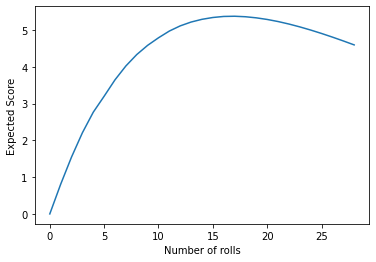

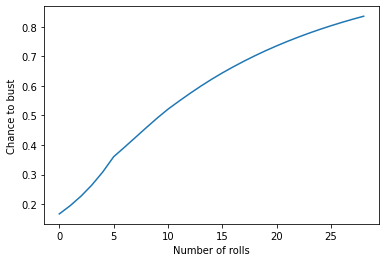

In [ ]:

def generalized_pig_E_and_P(target_score,p_bust,v_advance):
  #Purpose:
  #  Returns the expected value of playing the startegy of re-rolling until you hit target_score in generlized Pig
  #Input:
  #  target_score = Integer, represents the score to play until
  #  p_bust = real in (0,1), probability to go bust on any given roll
  #  v_advance = an array of shape (N_max,)(this is actually N_max + 1)
  #Output:
  #  expectedValue = A floating point number, represents the expected scores at target
  #  bustValue = A floating point number, represents the chance of busting at target
  
  # p_bust will be assumed to be constant.
  # declarations, honestly doing this outside the function once, and passing it through would be faster, but to make stuff simple I followed the function variables
  matrixLen = target_score + 2 # length includes bust state and 0 state
  x0 = jnp.zeros(matrixLen) # populates x0 with 0s.
  x0 = x0.at[1].set(1) # we assume x0 must have zero score to start. 
  N_max = jnp.size(v_advance)-1 #accounts for the phi state
  vToPutIn =  v_advance[2:N_max+1]*(1-p_bust)  # discard first state, for future use (we add one because thats how indicies work)

  tMatrix = makeMatrix(matrixLen,p_bust,N_max,vToPutIn) #this makes the transition matrix
  xNew = jnp.matmul(x0,jnp.linalg.matrix_power(tMatrix,target_score)) #runs the Markov chain

  scoresAsVector= jnp.transpose(jnp.array(list(range(matrixLen-2)))) # generates v_s
  expectedValue = (jnp.matmul(xNew[2:matrixLen],jnp.array(scoresAsVector))) #records the expected value
  bustValue = xNew[0] #records the bust value
  return expectedValue, bustValue

es = []
bs = []
for i in range(1,30):   
  e,b = generalized_pig_E_and_P(i,1/6,jnp.array([0,0,1/5,1/5,1/5,1/5,1/5]))   
  es.append(e)
  bs.append(b)
plt.figure(3)
toPlot1 = jnp.stack(es)
plt.plot(toPlot1)
plt.ylabel("Expected Score")
plt.xlabel("Number of rolls")
plt.figure(4)
toPlot2 = jnp.stack(bs)
plt.ylabel("Chance to bust")
plt.xlabel("Number of rolls")
plt.plot(toPlot2)
print(es[19])


## Final comments
Happily, the expected value for 20 rolls is extremely close to the actual value, especially when the result of 5.46 from (a) represents a non integer answer. As expected, $p_{bust}$ continues to increase as more rolls are done, though there is an interesting behavior between the first 5 rolls and after.


# 5(a) Solutions

This problem is about Can't Stop, a simple board game where players put runners in columns by rolling four six sided dice. This problem deals with finding the percent chance of a configuration of runners failing. <br/>
To do this, the super helpful function prob_to_miss_targets is used. The code for it is below. It takes an array of booleans and computes the percent change of missing the indices after rolling four dice. <br/> 



In [ ]:
from threading import Thread
def prob_to_miss_targets(targets): #shamelessly stolen from the final project file
  '''Compute the probability to miss a list of target cols'''
  #Input:
  #  targets = a boolean array of shape (11,) with which are targets
  #Output:
  #  A real number with the probability to miss all the targets from targets when rolling 4 dice and pairing them

  # Generates all possible dice rolls. Shape (4,6,6,6,6)
  four_dice_indices = jnp.indices((6,6,6,6)) 
  # Generates all possible combinations of dice. Shape (1,4)
  pairing = jnp.array([[1,1,0,0],[1,0,1,0],[1,0,0,1],[0,1,1,0],[0,1,0,1],[0,0,1,1]])
  # Records all sums for each type of paring. Shape (6,6,6,6,6)
  four_dice_pairings = jnp.einsum("iabcd,ji->jabcd",four_dice_indices,pairing)
  # One hot encodes all sums by parings. Shape (6, 6, 6, 6, 11)
  four_dice_pairings_one_hot = jnn.one_hot(four_dice_pairings,11)
  # Honestly not too sure what is done here, I think it sorts which of our targets are hit. Shape (6,6,6,6,6)
  hit_target = jnp.einsum("pabcdk,k->pabcd",four_dice_pairings_one_hot,targets)
  # Gives true for every target that is hit by any relavent pairings. Shape (6,6,6,6)
  any_hit_target = jnp.any(hit_target > 0, axis=0)
  # Checks the number of hits (False == zero == not hit). Shape, an integer
  number_of_dice_rolls_that_hit_target = jnp.count_nonzero(any_hit_target)
  # Converts back into a probability. 1296 = all possible combinations.
  return (1296- number_of_dice_rolls_that_hit_target)/1296


## The effect of runners:
Can't Stop has a very interesting rule when it comes to scoring. Unlike most games, the players choose where to score depending on what they initially roll. For example, a player first rolls $4,5,2,2$. This gives the possible scores as $9,4$ or $6,7$. The player then chooses to score in either and places runners in these columns. This choice means the first roll is effectively 'free' as any value (minus only rolling the already completed columns), is a success. Thus to chose $p_{bust}$ there are two main cases that must be considered. 

## Simple case:
Consider if there is a full set of runners. In this case the probability from prob_to_miss_targets exactly represents the chance to miss the runner columns. Provided a player can only put runners in columns that are not already completed, the runner position array just need to be converted into a boolean array. This can be done by subtracting the runner positions from a boolean array the same size as the illegals array, but only filled with True as its value. In code this is:
```python
jnp.ones_like(illegals) - runnerPos
```
Note the jnp.ones function generates a boolean array filled with trues of the desired size. This works since a negative number evaluates as False, so no matter the position of the runners (unless they are somehow negative) <br/> 

## Not as simple case:
Consider we have less than the full set of runners. In this case, the player can roll anything except the already filled columns. In other words, player only busts, if they only roll the filled columns. This can be computed as the  chance to miss everything but the illegal columns. This is represented by:
```python
prob_to_miss_targets(jnp.invert(illegals)) 
```
Note, the jnp.invert() function simply flips all boolean values.  <br />
Below is the code that computes the chance of missing.
## Code comments
> I have assumed that the runner positions being non zero implies a runner is currently in the column and not that the player has some progress in that column.  <br />


In [ ]:
def cant_stop_bust_probability(runner_col, illegal_col):
  N_Max_Runners = 3 # wasnt too sure if I should set this as a global variable or a local one
  # finds number of runners, 0 implies no runner in column.
  numOfRunners = jnp.count_nonzero(runner_col)
  # deals with the case of less runners than max
  if numOfRunners < N_Max_Runners: 
    # we only bust if we miss everything that isnt illegal
    pBust = prob_to_miss_targets(jnp.invert(illegal_col)) 
  # deals with the player having 3 runners (I assume we cannot stick a runner in an illegal position)
  else: 
    # jax numpy supports subtraction of these strings, which is super nice!
    realIllegal = jnp.ones_like(illegal_col) - runner_col  
    pBust = prob_to_miss_targets(realIllegal)
  return(pBust)

# simple test
print(f"p_bust of runners at 6,9,10, with one runner being 5 spaces in")
print(cant_stop_bust_probability(jnp.array([0,0,0,1,0,0,5,1,0,0,0]),jnp.array([False,False,False,False,True,False,False,False,False,False,False]))) 

print(f"p_bust of runners at 6,9,10, with all runners being 1 in") # should be the same as the first
print(cant_stop_bust_probability(jnp.array([0,0,0,1,0,0,1,1,0,0,0]),jnp.array([False,False,False,False,True,False,False,False,False,False,False]))) 

print(f"p_bust of no runners but an illegal, 4") # should only be one 4 dice roll that satisfies this (2,2,2,2)
print(cant_stop_bust_probability(jnp.array([0,0,0,0,0,0,0,0,0,0,0]),jnp.array([False,False,True,False,False,False,False,False,False,False,False]))) 
assert jnp.isclose(cant_stop_bust_probability(jnp.array([0,0,0,0,0,0,0,0,0,0,0]),jnp.array([False,False,True,False,False,False,False,False,False,False,False])), 1/1296)

print(f"p_bust of no runners but an illegal, 2") # should only be one 4 dice roll that satisfies this (1,1,1,1)
print(cant_stop_bust_probability(jnp.array([0,0,0,0,0,0,0,0,0,0,0]),jnp.array([True,False,False,False,False,False,False,False,False,False,False]))) 
assert jnp.isclose(cant_stop_bust_probability(jnp.array([0,0,0,0,0,0,0,0,0,0,0]),jnp.array([True,False,False,False,False,False,False,False,False,False,False])), 1/1296)


p_bust of runners at 6,9,10, with one runner being 5 spaces in
0.0069444445
p_bust of runners at 6,9,10, with all runners being 1 in
0.0069444445
p_bust of no runners but an illegal, 4
0.00077160494
p_bust of no runners but an illegal, 2
0.00077160494


## 5 (b) A simple AI

Consider using the $p_{bust}$ to somehow define an AI that chooses to roll or not. This can be done by connecting the game of PIG to Can't Stop. <br />  
PIG involves taking some $v$ vector of probabilities to scores, with $p_{bust}$ representing the chance to fail. <br />
The first realization does not have to deal with PIG. The AI should be to forced to get to max runners. This is forced since the chance of only hitting the illegal columns is extremely low as a maximum of 4 of the 12 columns can ever be forced to be illegal and hitting only four columns is a relatively low percentage. <br />
Past this the game of PIG can be connected in a very simple way and is best shown by defining the quantities $p_{bust}, v$ and the target score. <br />

To start, $p_{bust}$ is simply the chance to miss all runners, which can be computed by the previous function. <br />

The target score is more weirdly defined. The goal is to let the AI know if we should roll more or not. This can be done in a similar fashion to a player playing PIG where we let the AI roll until it achieves the optimal expected score. The best method to finding the optimal score is to run through all possible scores and see the highest expected value. As such the target score should range from $0$ to the highest needed score to complete a column. <br />

$v$ is the percent chance to obtain all scores and is the most difficult to define. Luckily a player can only obtain scores between 0 to $2$. The chance to obtain the a score of 0, is simply 0 since if no score is achieved, then the player busts. <br />
The chance to get at a score of at least one, is the chance to not miss all runners. This is represented by 1 minus the chance to miss all runner positions or:
```python
pUnBust = (1 - prob_to_miss_targets(jnp.ones_like(illegals) - runnerPos))
```
Finally, the chance to get a score of two, is the chance to get the same runner twice. This is the same as the inverted chance to hit any of the single runners. I will define this as $p_{unBust}$. Note this is different for every runner and mutually exclusive. Thus, the chance to get this becomes 
```python
jnp.sum(prob_to_miss_targets(invert(jnp.ones_like(illegals) - runner1)) + prob_to_miss_targets(invert(jnp.ones_like(illegals) - runner2)) + prob_to_miss_targets(invert(jnp.ones_like(illegals) - runner3)))
```
Using all of these parameters, and the previous generalize PIG, the AI would choose the maximally found expected value and roll until getting to this point.



## Code comments
> To find the optimal score to roll for the maximum value of the expected values is found. This uses:
```python
jnp.amax()
```
> To simulating rolling, I simply put a runner on any of the open slots until they were full. <br />


In [190]:


def simple_roll_again_AI(runner_col, illegal_col, currentProgress = 0, targetScore = -1):
  #Purpose:
  #  Determine wheter or not to roll again or not in Can't stop given ONLY the current state of the runners and the illegal columns
  #  (Note: A better AI would take into account the player positions too, but we are making a very simple AI here)
  #Input:
  #  runner_col = an array of shape (11,) of integers with the runner locations
  #  illegal_col = an array of shape (11,) of boolean with which columns are illegal to play in 
  #NOTE:
  #  We assume N_Max_Runners = 3 for this one!

  rollAgain = False # by default, the player does not roll again
  numOfRunners = jnp.count_nonzero(runner_col) # checks the number of runners

  if numOfRunners < 3: # if less than max, we might as well roll again since the chance is super low to bust
    return(True,-1)
  if targetScore < 0: # checks if we have computed a targetScore, if not we compute it and start recording our number of rolls
    pBust = cant_stop_bust_probability(runner_col,illegal_col) # this uses the simple part of 5a to compute the chance to bust
    runPos = jnp.array([]) 
    for i in range(jnp.size(runner_col)): # this finds where the runners are, since it is needed to generate the v vector
      if runner_col[i] > 0:
        runPos = jnp.append(runPos,i)
    pUnbust = 0 # this represents the chance to attain a score of 2
    for runP in runPos:
      a = jnp.ones_like(illegal_col)
      a = a.at[int(runP)].set(0)
      pUnbust += prob_to_miss_targets(jnp.invert(a)) # this generates the chance to only hit one of the runners twice, the result is added since each are mutually exlusive
    v = jnp.array([0,0,0]) # since we have the chance to miss, as well as the chance to 
    v = v.at[1].set(1-pBust)
    v = v.at[2].set(pUnbust)
    es = []
    for i in range(1,12):
      e = generalized_pig_E_and_P(i,pBust,v)
      es.append(e)
    targetScore = jnp.amax(jnp.array(es))
  if targetScore < currentProgress:
    rollAgain = True
  
  return(rollAgain,targetScore)

roll = 1 # assume we roll at least once
prog = 0 # start with no progres
target = -1 # have no targetScore yet


runner_col = jnp.array([0,0,0,0,0,0,0,0,0,0,0]) # no runners out
illegal_col = jnp.array([False,False,False,False,True,False,False,False,False,False,False]) # one completed column on 6
while roll == 1:
  roll,target = simple_roll_again_AI(runner_col,illegal_col,prog,target)
  prog += 1 
  if jnp.count_nonzero(runner_col) < 3: # checks the number of runners
    runner_col = runner_col.at[random.randint(0,11)].set(1) # simulates rolling and adding in runners
print(f"The AI rolled {prog} times.")
print(f"The final runner positions are: \n {runner_col}")



The AI rolled 4 times.
The final runner positions are: 
 [1 0 0 0 0 0 0 1 0 1 0]
